In [1]:
library(tidyverse)
library(arcadiathemeR)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [2]:
setwd("..")

In [3]:
virus_colors <- c(
  "Adenoviridae" = "#F898AE",
  "Astroviridae" = "#73B5E3",
  "Herpesviridae" = "#FFB984",
  "Caliciviridae" = "#F5E4BE",
  "Poxviridae" = "#BABEE0",
  "Picornaviridae" = "#97CD78",
  "Potyviridae" = "#5088C5",
  "Coronaviridae" = "#F28360"
)

In [54]:
virus_types <- data.frame(
  family = c(
    "Poxviridae", "Herpesviridae", "Betaflexiviridae", "Orthomyxoviridae", 
    "Nairoviridae", "Reoviridae", "Papillomaviridae", "Coronaviridae", 
    "Adenoviridae", "Flaviviridae", "Paramyxoviridae", "Potyviridae", 
    "Pneumoviridae", "Filoviridae", "Geminiviridae", "Arenaviridae", 
    "Anelloviridae", "Hepeviridae", "Astroviridae", "Rhabdoviridae", 
    "Parvoviridae", "Peribunyaviridae", "Secoviridae", "Picornaviridae", 
    "Caliciviridae", "Togaviridae", "Tombusviridae", "Polyomaviridae", 
    "Hepadnaviridae", "Genomoviridae", "Phenuiviridae", "Solemoviridae", 
    "Bromoviridae", "Circoviridae", "Redondoviridae", "undefined_family", 
    "Retroviridae", "Virgaviridae", "Smacoviridae", "Matonaviridae", 
    "Mesoniviridae", "Kolmioviridae"
  ),
  virus_type = c(
    "dsDNA", "dsDNA", "ssRNA+", "ssRNA-", 
    "ssRNA-", "dsRNA", "dsDNA", "ssRNA+", 
    "dsDNA", "ssRNA+", "ssRNA-", "ssRNA+", 
    "ssRNA-", "ssRNA-", "ssDNA", "ssRNA-", 
    "ssDNA", "ssRNA+", "ssRNA+", "ssRNA-", 
    "ssDNA", "ssRNA-", "ssRNA+", "ssRNA+", 
    "ssRNA+", "ssRNA+", "ssRNA+", "dsDNA", 
    "dsDNA-RT", "ssDNA", "ssRNA-", "ssRNA+", 
    "ssRNA+", "ssDNA", "ssDNA", "unknown", 
    "ssRNA-RT", "ssRNA+", "ssDNA", "ssRNA+", 
    "ssRNA+", "ssRNA+"
  )
)

In [56]:
viral_structure_metadata <- read_tsv("outputs/viral/human/viral_structure_metadata.tsv", show_col_types = FALSE) %>%
 filter(family != "Staphylococcaceae") %>%
 left_join(virus_types, by = "family")
colnames(viral_structure_metadata)
nrow(viral_structure_metadata)

[1] "nomburg_cluster_id"             "nomburg_cluster_representative"
 [3] "nomburg_protein_name"           "gene_name"                     
 [5] "ncbi_id"                        "virus"                         
 [7] "taxon_id"                       "nomburg_cluster_count"         
 [9] "superkingdom"                   "phylum"                        
[11] "class"                          "order"                         
[13] "family"                         "genus"                         
[15] "species"                        "structure_filepaths"           
[17] "virus_type"

[1] 5792

In [78]:
# how many potential virus-host relationships?
read_tsv("inputs/viral/virushostdb.tsv") %>%
  filter(`host tax id` == 9606) %>%
  nrow()

Rows: 36470 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): virus name, virus lineage, refseq id, KEGG GENOME, KEGG DISEASE, D...
dbl  (3): virus tax id, host tax id, source organism

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 1488

In [72]:
length(unique(viral_structure_metadata$virus))
length(unique(viral_structure_metadata$species))


[1] 349

[1] 348

In [57]:
nomburg_taxonomy <-  viral_structure_metadata %>%
  select(taxon_id, virus, virus_type, superkingdom, phylum, class, order, family, genus, species) 

nrow(nomburg_taxonomy)

[1] 5792

In [68]:
nomburg_taxonomy_tally <- nomburg_taxonomy %>%
  group_by(virus_type, phylum, class, order, family) %>%
  tally() %>%
  ungroup() %>%
  select(-virus_type)

In [51]:
make_agglom_cols <- function(tax_glom_level){
  if(tax_glom_level == "phylum"){
    agglom_cols <- c("phylum")
  } else if(tax_glom_level == "class"){
    agglom_cols <- c("phylum", "class")
  } else if(tax_glom_level == "order"){
    agglom_cols <- c("phylum", "class", "order")
  } else if(tax_glom_level == "family"){
    agglom_cols <- c("phylum", "class", "order", "family")
  } else if(tax_glom_level == "genus"){
    agglom_cols <- c("phylum", "class", "order", "family", "genus")
  } else if(tax_glom_level == "species"){
    agglom_cols <- c("phylum", "class", "order", "family", "genus", "species")
  }


    return(agglom_cols)
}
      
plot_taxonomy_annotate_sankey <- function(taxonomy_annotate_df, tax_glom_level = NULL, palette = NULL, label = TRUE){
  if(!is.null(tax_glom_level)){
    agglom_cols <- make_agglom_cols(tax_glom_level = tax_glom_level)
  } else {
    agglom_cols <- c("phylum", "class", "order", "family", "genus", "species", "virus")
    # check if there are NAs in the strain column and emit a warning, as these will be dropped and the plot will look weird
    if(sum(is.na(taxonomy_annotate_df$virus)) > 0){
      stop("Some lineages are missing strain information. This will lead computation to fail for stat_parallel_sets_axes(). Use tax_glom_level = 'species' or a higher taxonomic rank to produce a plot")
    }
  }

  for (col in agglom_cols) {
    taxonomy_annotate_df[[col]] <- factor(taxonomy_annotate_df[[col]], 
                                          levels = unique(taxonomy_annotate_df[[col]]))
  }
    
  # format for ggforce parallel sets
  data <- ggforce::gather_set_data(taxonomy_annotate_df, 1:length(agglom_cols))

  # create a palette that recycles colors so each taxonomic label will be colorful
  if(is.null(palette)){
    # if the user doesn't supply a palette, use Set2
    palette <- c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
  }
  # otherwise ramp up from the user-defined palette
  palette <- grDevices::colorRampPalette(palette)(length(unique(data$y)))

  sankey_plt <- ggplot2::ggplot(data, ggplot2::aes(x = .data$x, id = .data$id, split = .data$y, value = .data$n)) +
    ggforce::geom_parallel_sets(alpha = 0.3, axis.width = 0.1) +
    ggforce::geom_parallel_sets_axes(axis.width = 0.2, fill = "grey") +
    #ggforce::geom_parallel_sets_axes(axis.width = 0.2, ggplot2::aes(fill = .data$y)) +
    ggplot2::theme_classic() +
    ggplot2::theme(axis.line.y = ggplot2::element_blank(),
                   axis.text.y = ggplot2::element_blank(),
                   axis.ticks.y = ggplot2::element_blank(),
                   axis.ticks.x = ggplot2::element_blank(),
                   legend.position = "None") +
    ggplot2::labs(x = "taxonomic rank") +
    # buffer the last axis so full names have space to print to viz
    ggplot2::scale_x_continuous(labels = c(agglom_cols, ""),
                                breaks = 1:(length(agglom_cols) + 1),
                                limits = c(.75, length(agglom_cols) + 1)) #+
    #ggplot2::scale_fill_manual(values = palette)

  if(label == TRUE){
    sankey_plt <- sankey_plt +
      ggforce::geom_parallel_sets_labels(colour = 'black', angle = 360, size = 2, hjust = -0.25)
  }

  return(sankey_plt)
}

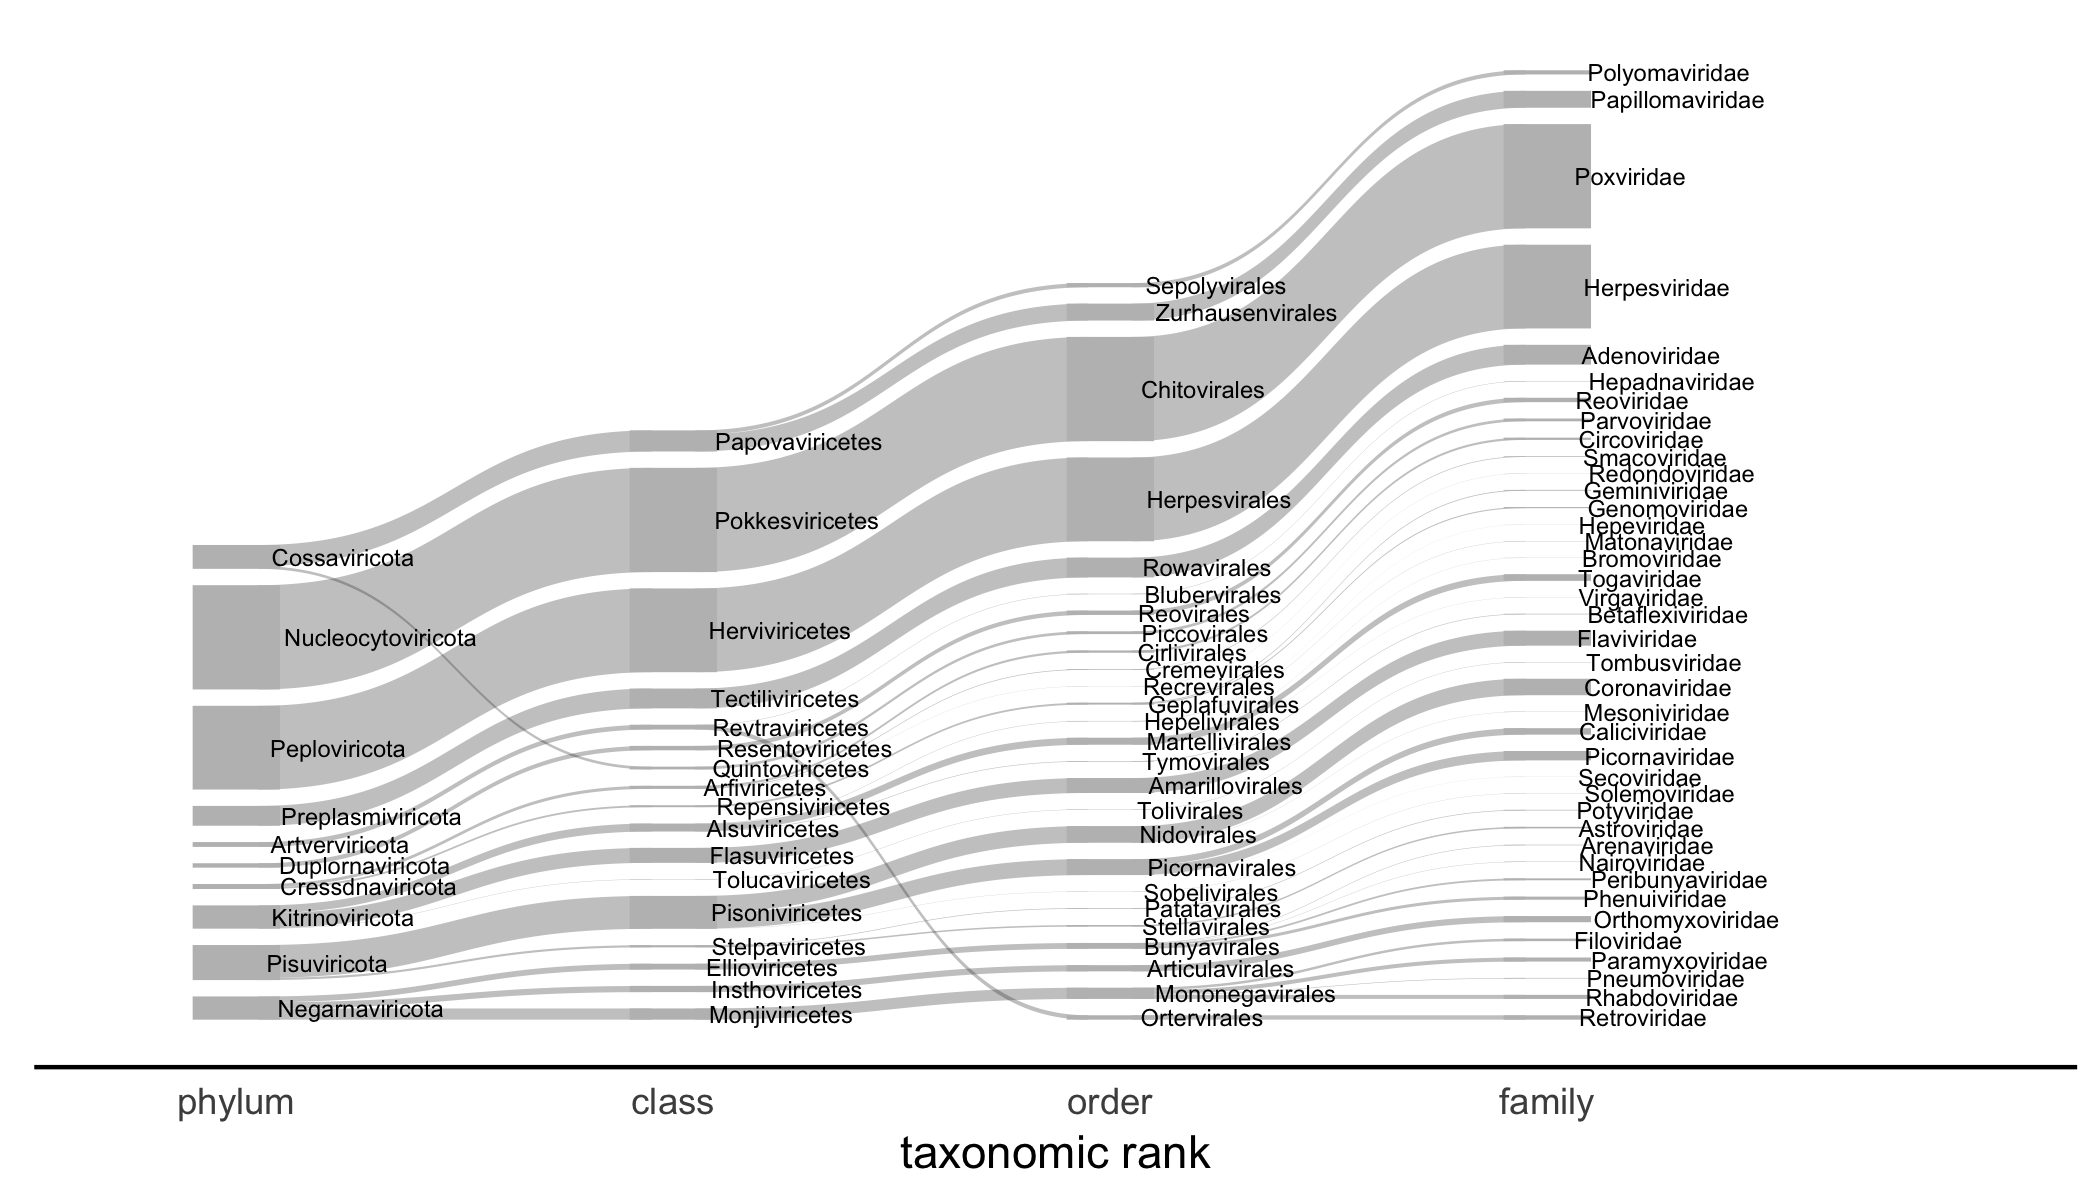

In [67]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

plot_taxonomy_annotate_sankey(taxonomy_annotate_df = nomburg_taxonomy_tally %>% filter(!is.na(phylum)), tax_glom_level = "family")

## Now plot a sankey only of structures that had a hit (e < 0.01)

In [95]:
nomburg_virus_matches <- read_tsv("outputs/viral/human/nomburg_virus_matches_with_metadata.tsv", show_col_type = FALSE) %>%
  rowwise() %>%
  mutate(min_tmscore = min(alntmscore, qtmscore, ttmscore),
         max_tmscore = max(alntmscore, qtmscore, ttmscore),
         avg_tmscore = sum(alntmscore, qtmscore, ttmscore) / 3 ) %>%
  ungroup() %>%
  group_by(query) %>%
  slice_min(evalue) %>%
  slice_max(max_tmscore) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  filter(query_family != "Staphylococcaceae") %>%
  left_join(virus_types, by = c("query_family" = "family")) 

In [96]:
nrow(nomburg_virus_matches)
length(unique(nomburg_virus_matches$query))

[1] 2063

[1] 2063

In [91]:
nomburg_virus_matches_tally <- nomburg_virus_matches %>%
  group_by(virus_type, query_phylum, query_class, query_order, query_family) %>%
  tally() %>%
  ungroup() %>%
  select(-virus_type) %>%
  rename(phylum = query_phylum, class = query_class, order = query_order, family = query_family)

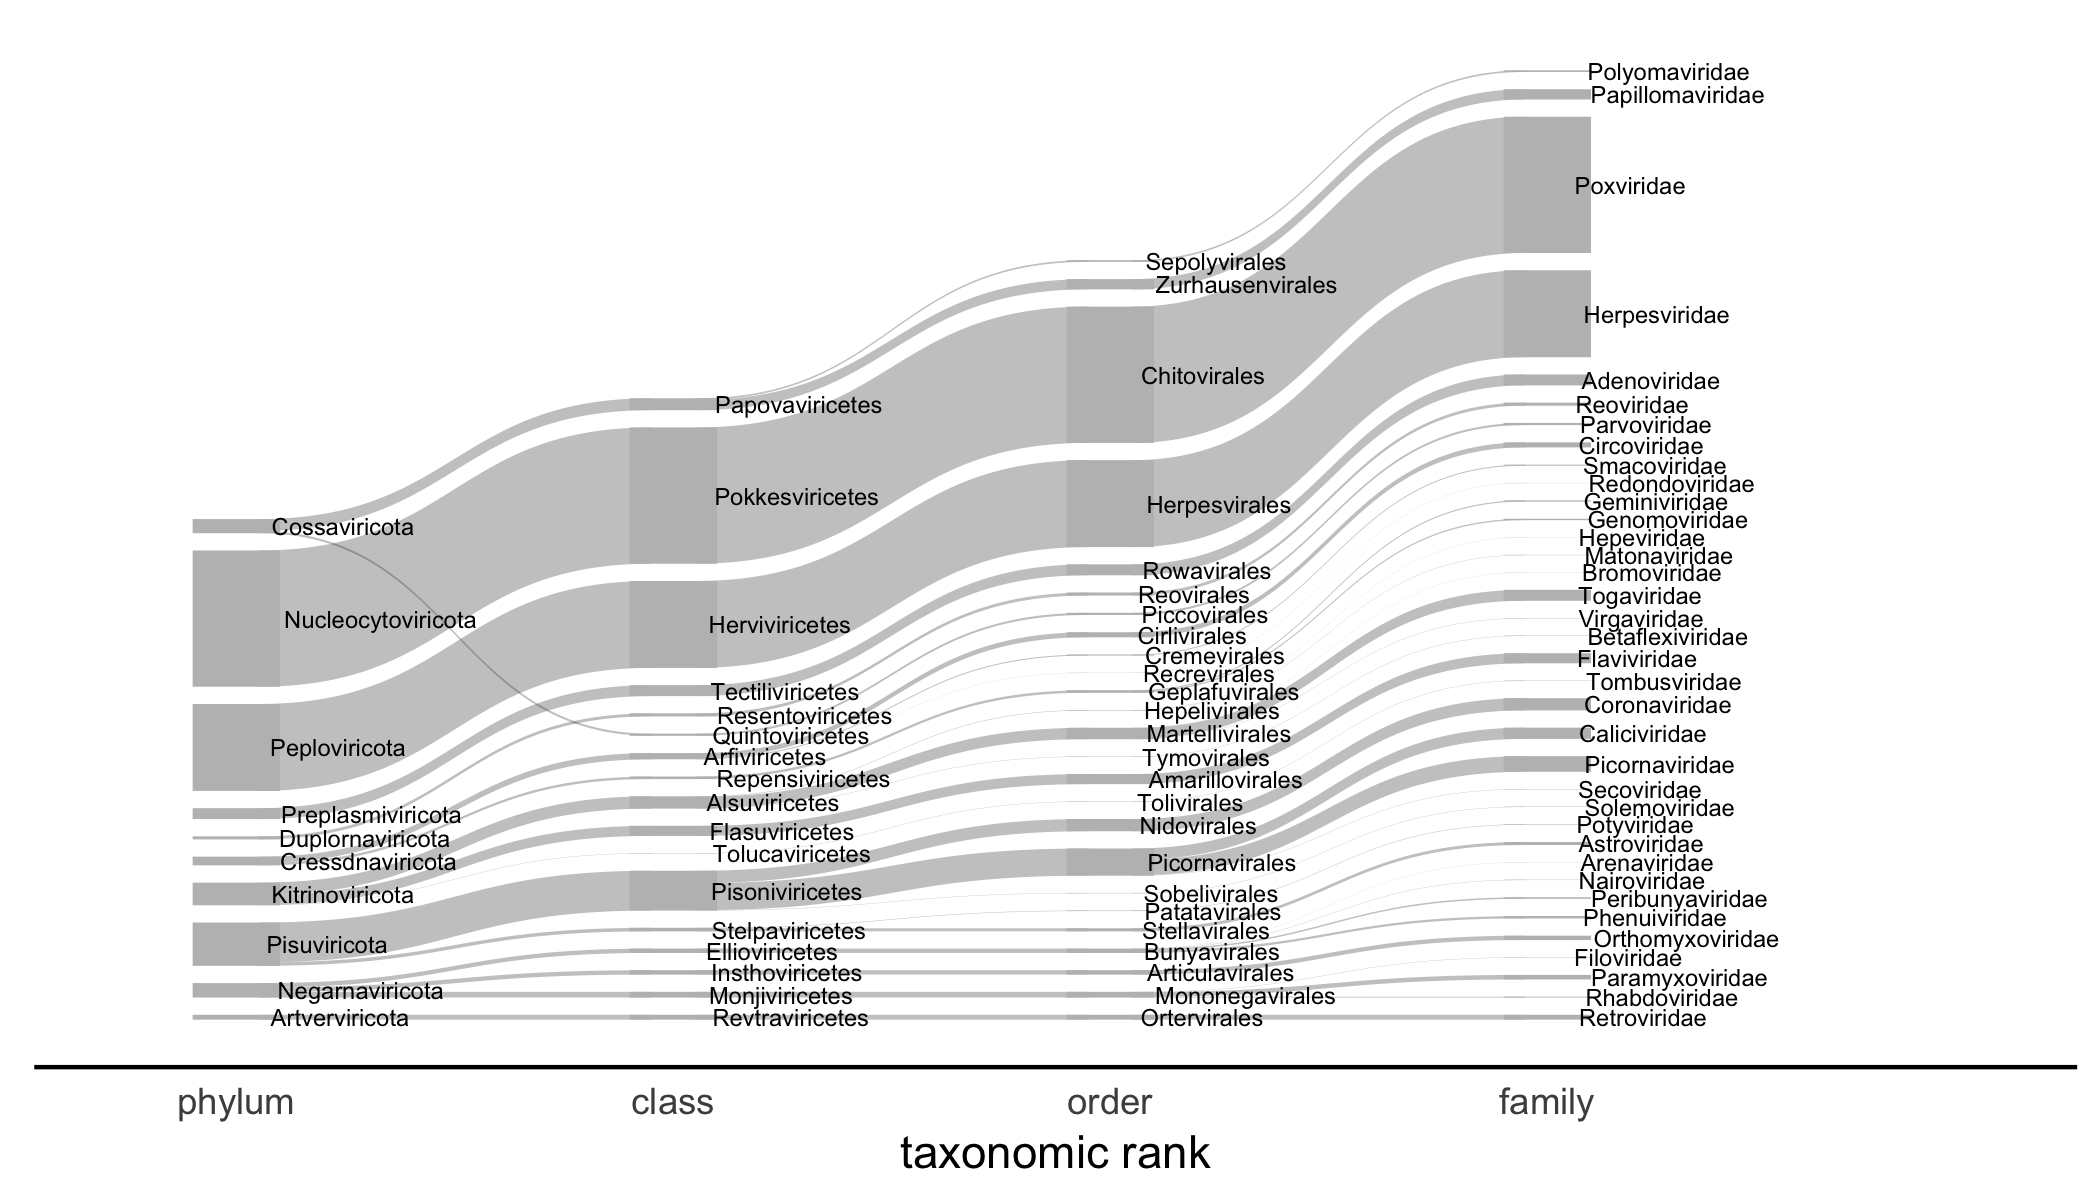

In [92]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

plot_taxonomy_annotate_sankey(taxonomy_annotate_df = nomburg_virus_matches_tally %>% filter(!is.na(phylum)), tax_glom_level = "family")

## Plot distributions for hits (e < 0.01 and min e-value only filters)

In [167]:
head(nomburg_virus_matches$virus_type)

[1] "dsDNA" "dsDNA" "dsDNA" "dsDNA" "dsDNA" "dsDNA"

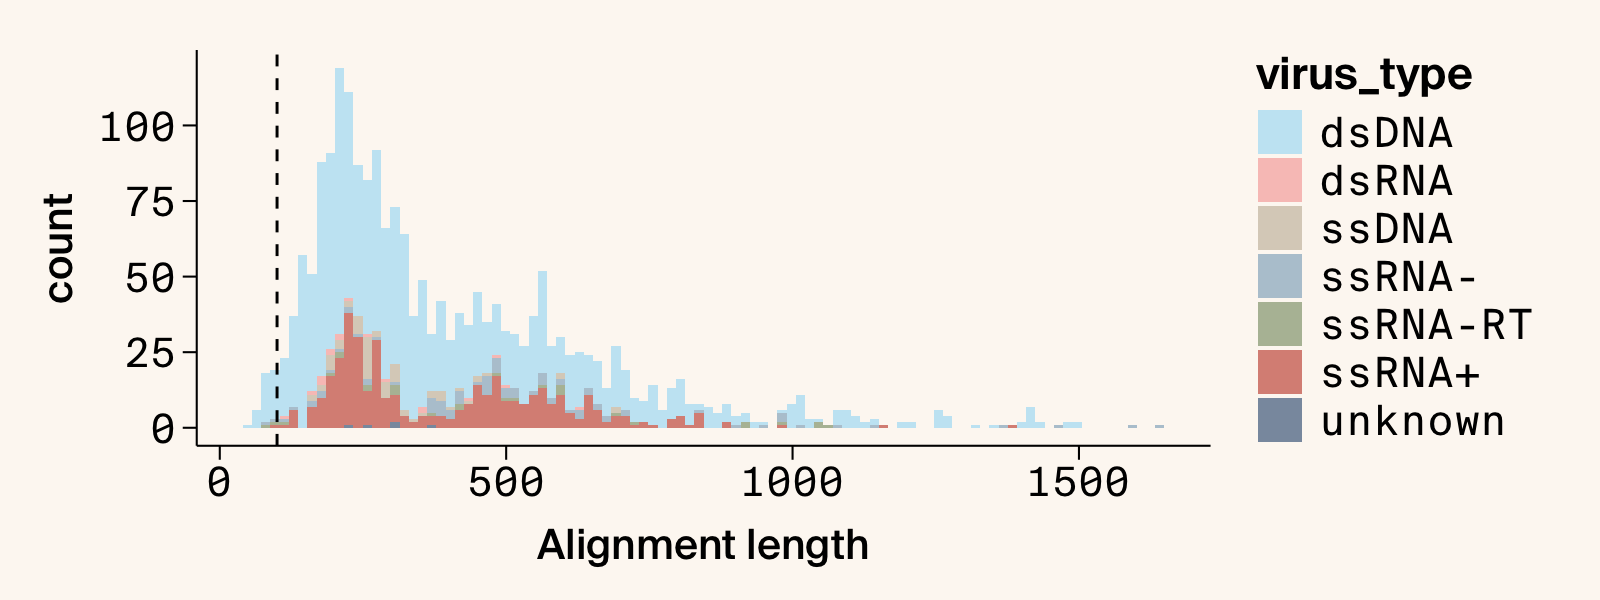

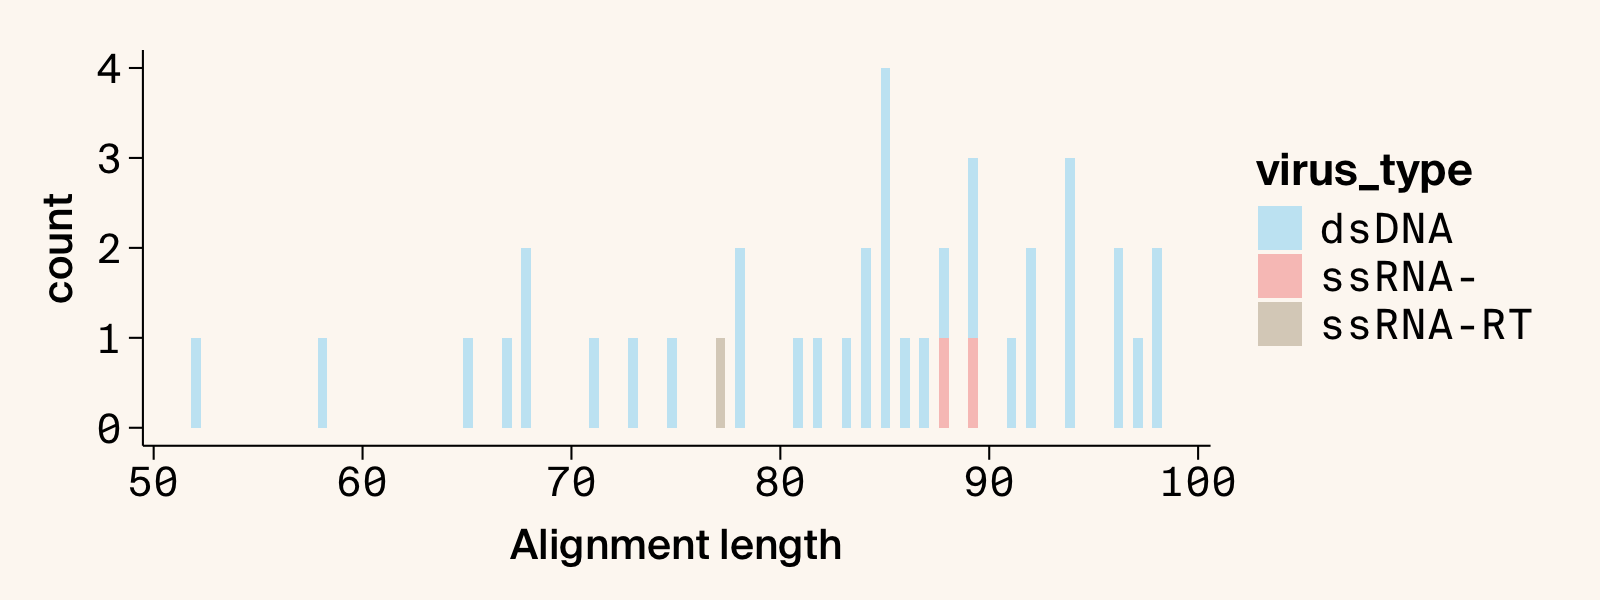

In [175]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 200)

ggplot(nomburg_virus_matches, aes(x = alnlen, fill = virus_type)) + 
  geom_histogram(bins = 100) + 
  geom_vline(xintercept = 100, linetype = "dashed") +
  theme_arcadia() +
  labs(x = "Alignment length") +
  scale_fill_arcadia("secondary")


ggplot(nomburg_virus_matches %>% filter(alnlen < 100), aes(x = alnlen, fill = virus_type)) + 
  geom_histogram(bins = 100) + 
  theme_arcadia() +
  labs(x = "Alignment length") +
  scale_fill_arcadia("secondary")

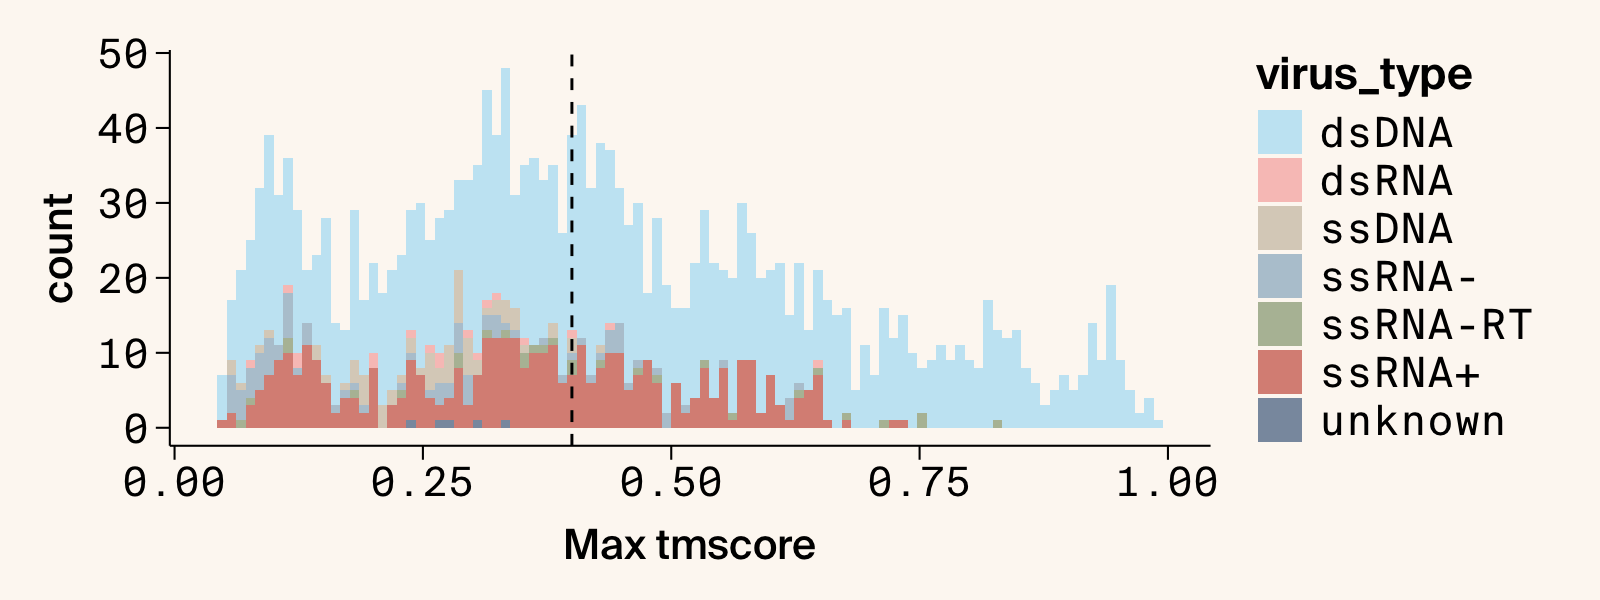

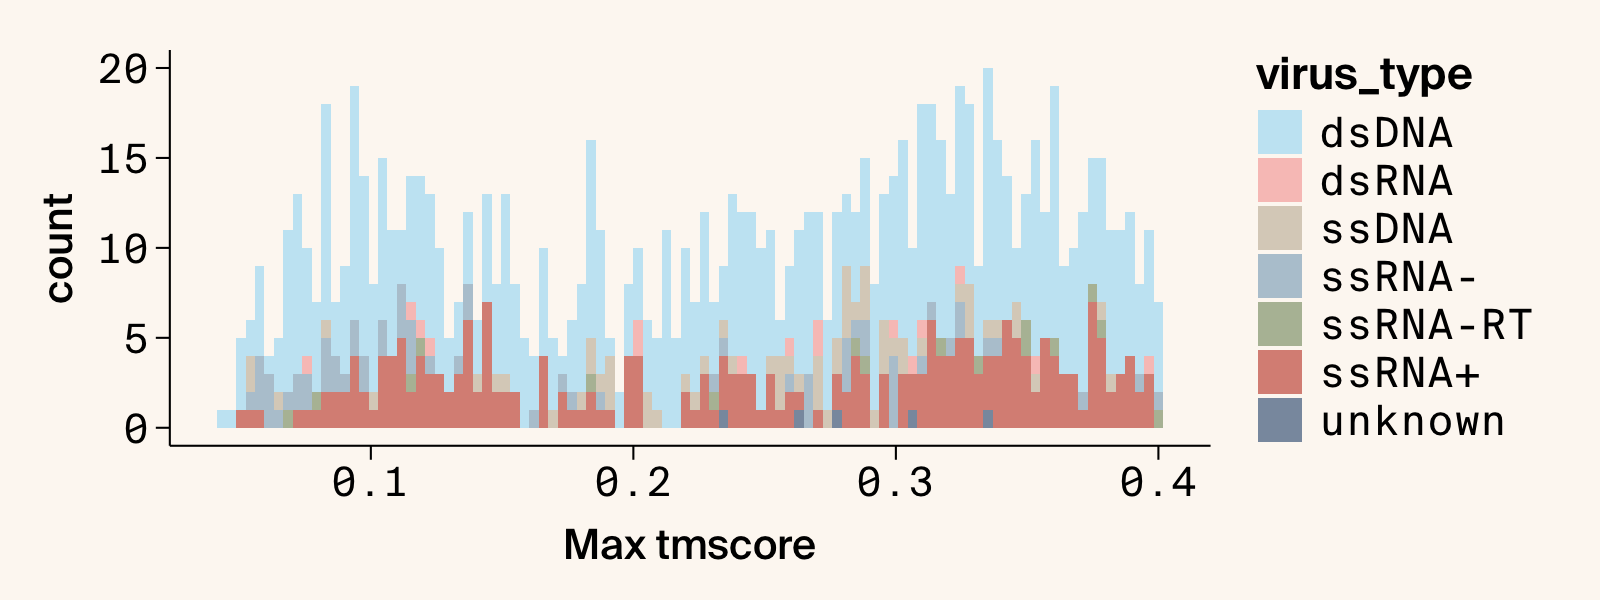

In [179]:
ggplot(nomburg_virus_matches, aes(x = max_tmscore, fill = virus_type)) + 
  geom_histogram(bins = 100) + 
  geom_vline(xintercept = 0.4, linetype = "dashed") +
  theme_arcadia() +
  labs(x = "Max tmscore") +
  scale_fill_arcadia("secondary")


ggplot(nomburg_virus_matches %>% filter(max_tmscore < 0.4), aes(x = max_tmscore, fill = virus_type)) + 
  geom_histogram(bins = 100) + 
  theme_arcadia() +
  labs(x = "Max tmscore") +
  scale_fill_arcadia("secondary")

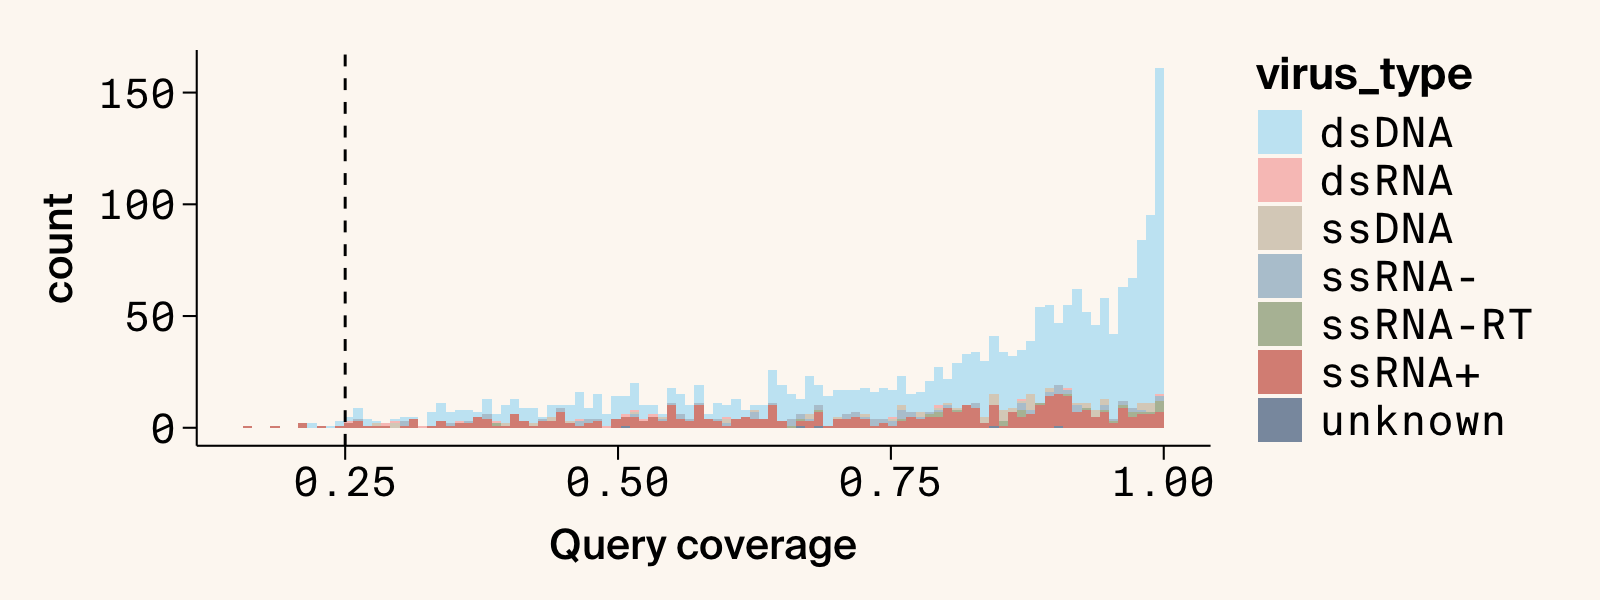

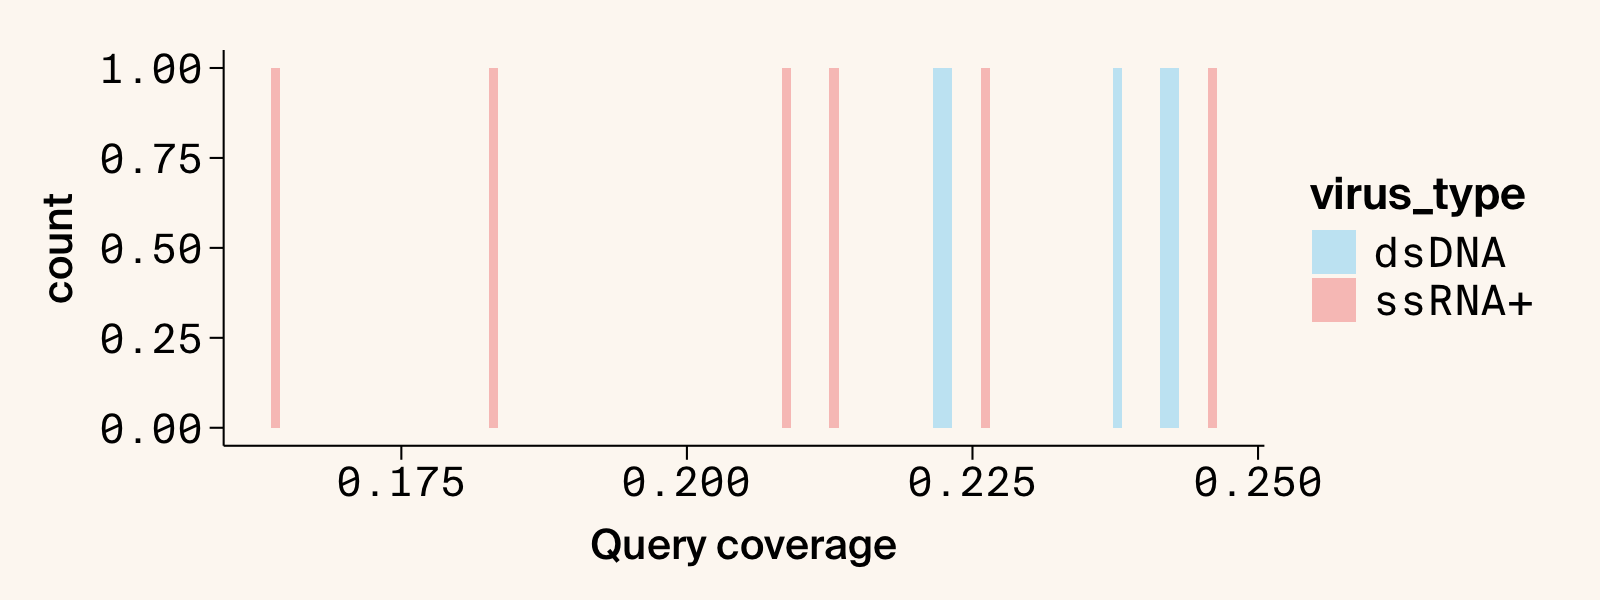

In [184]:
ggplot(nomburg_virus_matches, aes(x = qcov, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  geom_vline(xintercept = 0.25, linetype = "dashed") +
  theme_arcadia() + 
  labs(x = "Query coverage") +
  scale_fill_arcadia("secondary")

ggplot(nomburg_virus_matches %>% filter(qcov < 0.25), aes(x = qcov, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  theme_arcadia() + 
  labs(x = "Query coverage") +
  scale_fill_arcadia("secondary")

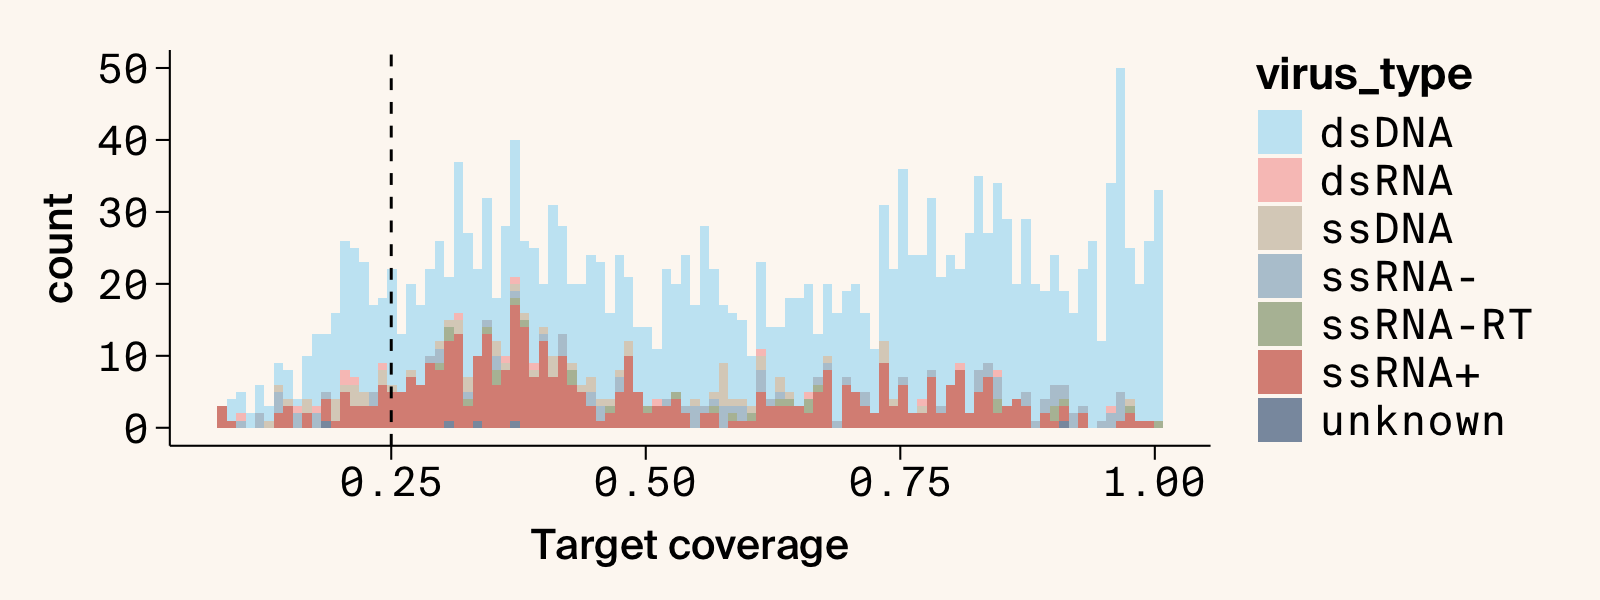

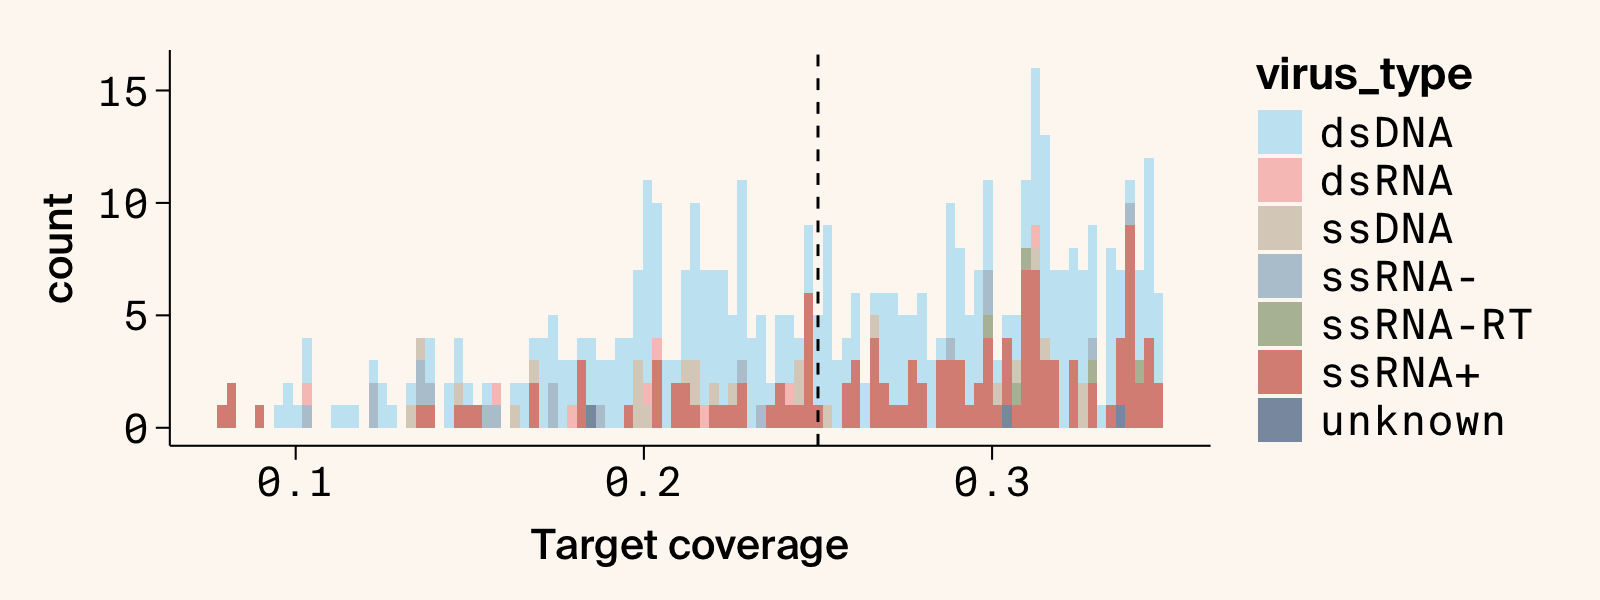

In [191]:
ggplot(nomburg_virus_matches, aes(x = tcov, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  geom_vline(xintercept = 0.25, linetype = "dashed") +
  theme_arcadia() + 
  labs(x = "Target coverage") +
  scale_fill_arcadia("secondary")

ggplot(nomburg_virus_matches %>% filter(tcov < 0.35), aes(x = tcov, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  geom_vline(xintercept = 0.25, linetype = "dashed") +
  theme_arcadia() + 
  labs(x = "Target coverage") +
  scale_fill_arcadia("secondary")

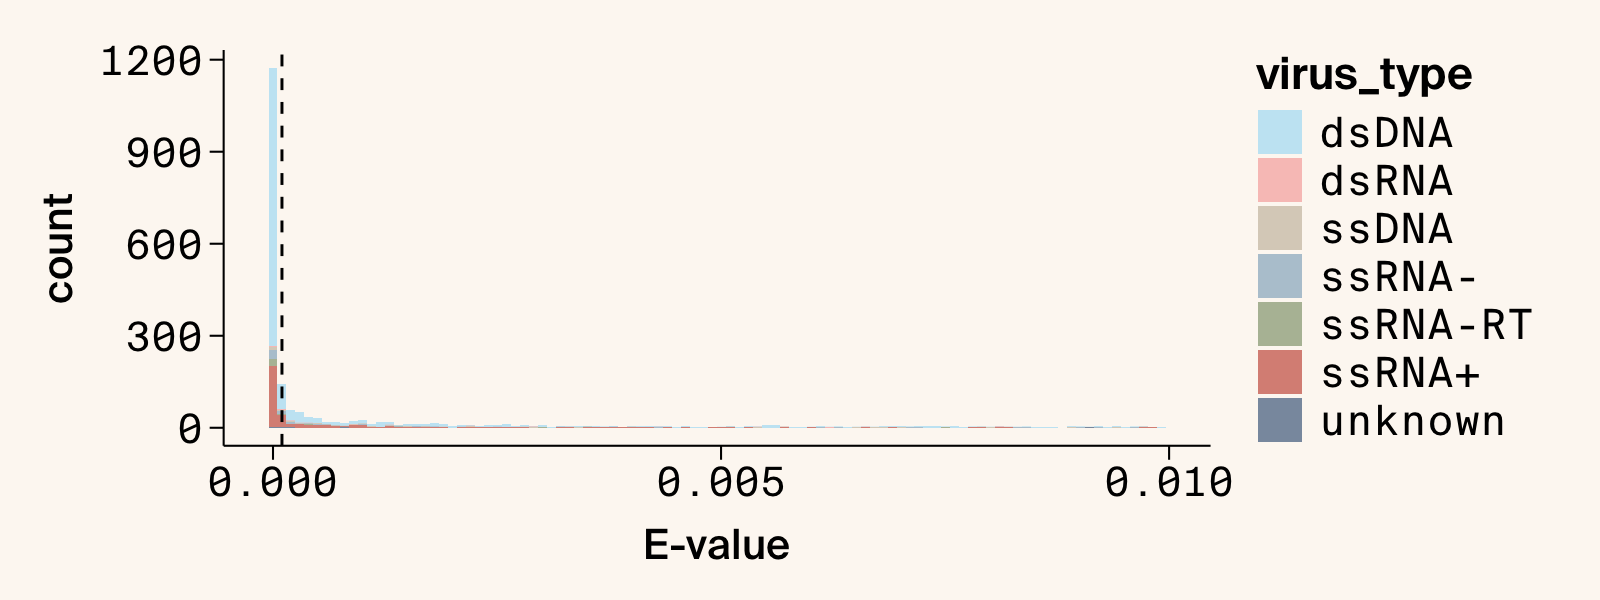

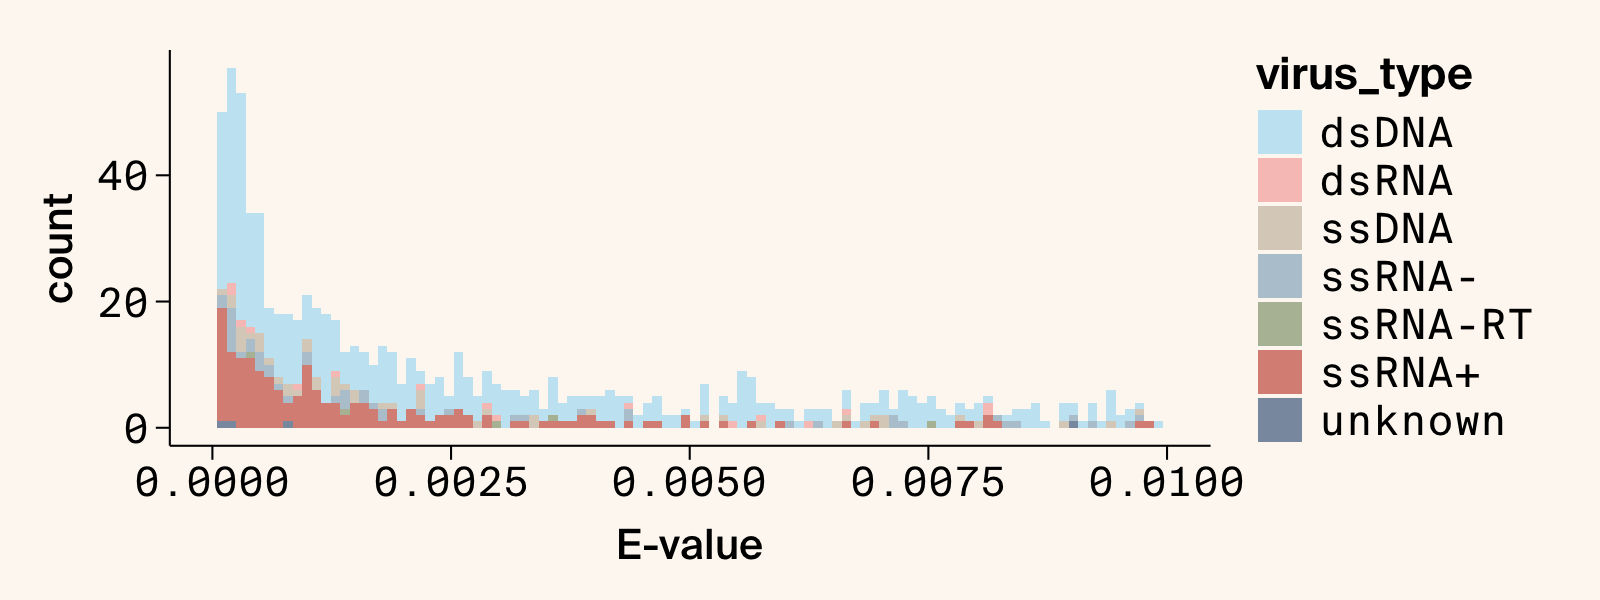

In [197]:
ggplot(nomburg_virus_matches, aes(x = evalue, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  geom_vline(xintercept = 0.0001, linetype = "dashed") +
  theme_arcadia() + 
  labs(x = "E-value")+
  scale_x_continuous(breaks = c(0, 0.005, 0.01)) +
  scale_fill_arcadia("secondary")


ggplot(nomburg_virus_matches %>% filter(evalue > 0.0001), aes(x = evalue, fill = virus_type)) + 
  geom_histogram(bins = 100) +
  theme_arcadia() + 
  labs(x = "E-value")+
  #scale_x_continuous(breaks = c(0, 0.005, 0.01)) +
  scale_fill_arcadia("secondary")

## Number of starting structures vs. number of hits

In [115]:
colnames(nomburg_virus_matches)

[1] "query_species"                                                                                        
  [2] "query"                                                                                                
  [3] "target"                                                                                               
  [4] "qlen"                                                                                                 
  [5] "tlen"                                                                                                 
  [6] "alnlen"                                                                                               
  [7] "alntmscore"                                                                                           
  [8] "qtmscore"                                                                                             
  [9] "ttmscore"                                                                                             
 [10] "host_gene_names_primary"                                                                              
 [11] "host_function_cc"                                                                                     
 [12] "host_tissue_specificity"                                                                              
 [13] "host_subcellular_location_cc"                                                                         
 [14] "lddt"                                                                                                 
 [15] "prob"                                                                                                 
 [16] "qcov"                                                                                                 
 [17] "tcov"                                                                                                 
 [18] "pident"                                                                                               
 [19] "bits"                                                                                                 
 [20] "evalue"                                                                                               
 [21] "cigar"                                                                                                
 [22] "qseq"                                                                                                 
 [23] "tseq"                                                                                                 
 [24] "qstart"                                                                                               
 [25] "qend"                                                                                                 
 [26] "tstart"                                                                                               
 [27] "tend"                                                                                                 
 [28] "qaln"                                                                                                 
 [29] "taln"                                                                                                 
 [30] "host_entry"                                                                                           
 [31] "host_entry_name"                                                                                      
 [32] "host_protein_names"                                                                                   
 [33] "host_annotation"                                                                                      
 [34] "host_organism"                                                                                        
 [35] "host_taxonomic_lineage"                                                                               
 [36] "host_length"                                                                                          
 [37] "host_fragment"                     

In [122]:
nomburg_virus_matches_tally2 <- nomburg_virus_matches %>%
  group_by(virus_type, query_phylum, query_class, query_order, query_family, query_genus, query_species, query_virus) %>%
  tally() %>%
  ungroup() %>%
  rename(phylum = query_phylum, class = query_class, order = query_order, family = query_family, 
         genus = query_genus, species = query_species, virus = query_virus, n_hits = n)

In [123]:
nomburg_taxonomy_tally2 <- nomburg_taxonomy %>%
  group_by(virus_type, phylum, class, order, family, genus, species, virus) %>%
  tally() %>%
  ungroup() %>%
  rename(n_query_structures = n)

In [127]:
hits_vs_structures <- left_join(nomburg_taxonomy_tally2, nomburg_virus_matches_tally2) %>%
  replace_na(list(n_hits = 0))

Joining with `by = join_by(virus_type, phylum, class, order, family, genus, species, virus)`


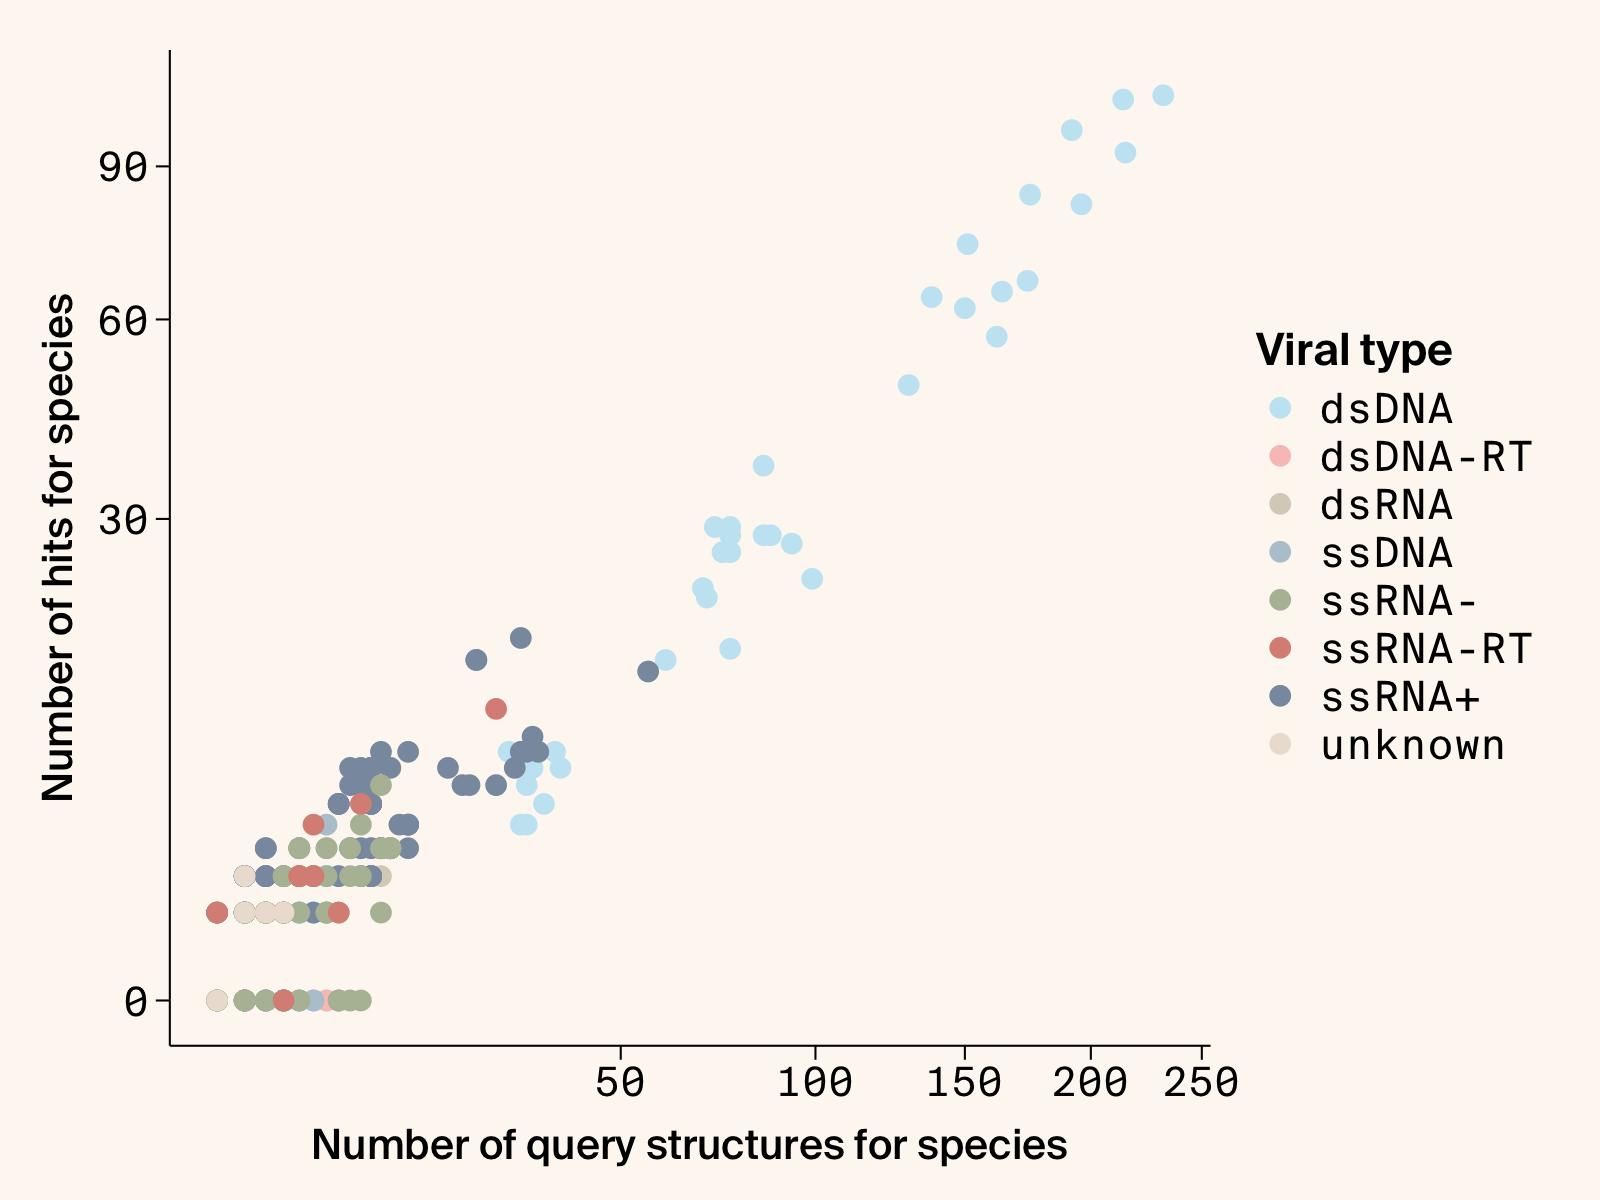

In [164]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)

ggplot(hits_vs_structures, aes(x = n_query_structures, y = n_hits, color = virus_type)) +
  geom_point(size = 3) +
  theme_arcadia() +
  labs(x = "Number of query structures for species", y="Number of hits for species", color = "Viral type") +
  scale_x_sqrt() +
  scale_y_sqrt() +
  scale_color_arcadia(palette = "secondary")

## Make the same plot, but for the filter criteria 1

In [137]:
filter_criteria1 <- read_csv("outputs/viral/all_nomburg_virus_matches_with_metadata_filtered_criteria1.csv", show_col_types = FALSE) %>%
  mutate(host_organism = gsub(" \\(.*", "", host_organism)) %>%
  filter(host_organism == "Homo sapiens")

In [140]:
filter_criteria1_tally <- filter_criteria1 %>%
  group_by(query_phylum, query_class, query_order, query_family, query_genus, query_species, query_virus) %>%
  tally() %>%
  ungroup() %>%
  rename(phylum = query_phylum, class = query_class, order = query_order, family = query_family, 
         genus = query_genus, species = query_species, virus = query_virus, n_hits = n)

In [141]:
filtercriteria1_vs_structures <- left_join(nomburg_taxonomy_tally2, filter_criteria1_tally) %>%
  replace_na(list(n_hits = 0))

Joining with `by = join_by(phylum, class, order, family, genus, species, virus)`


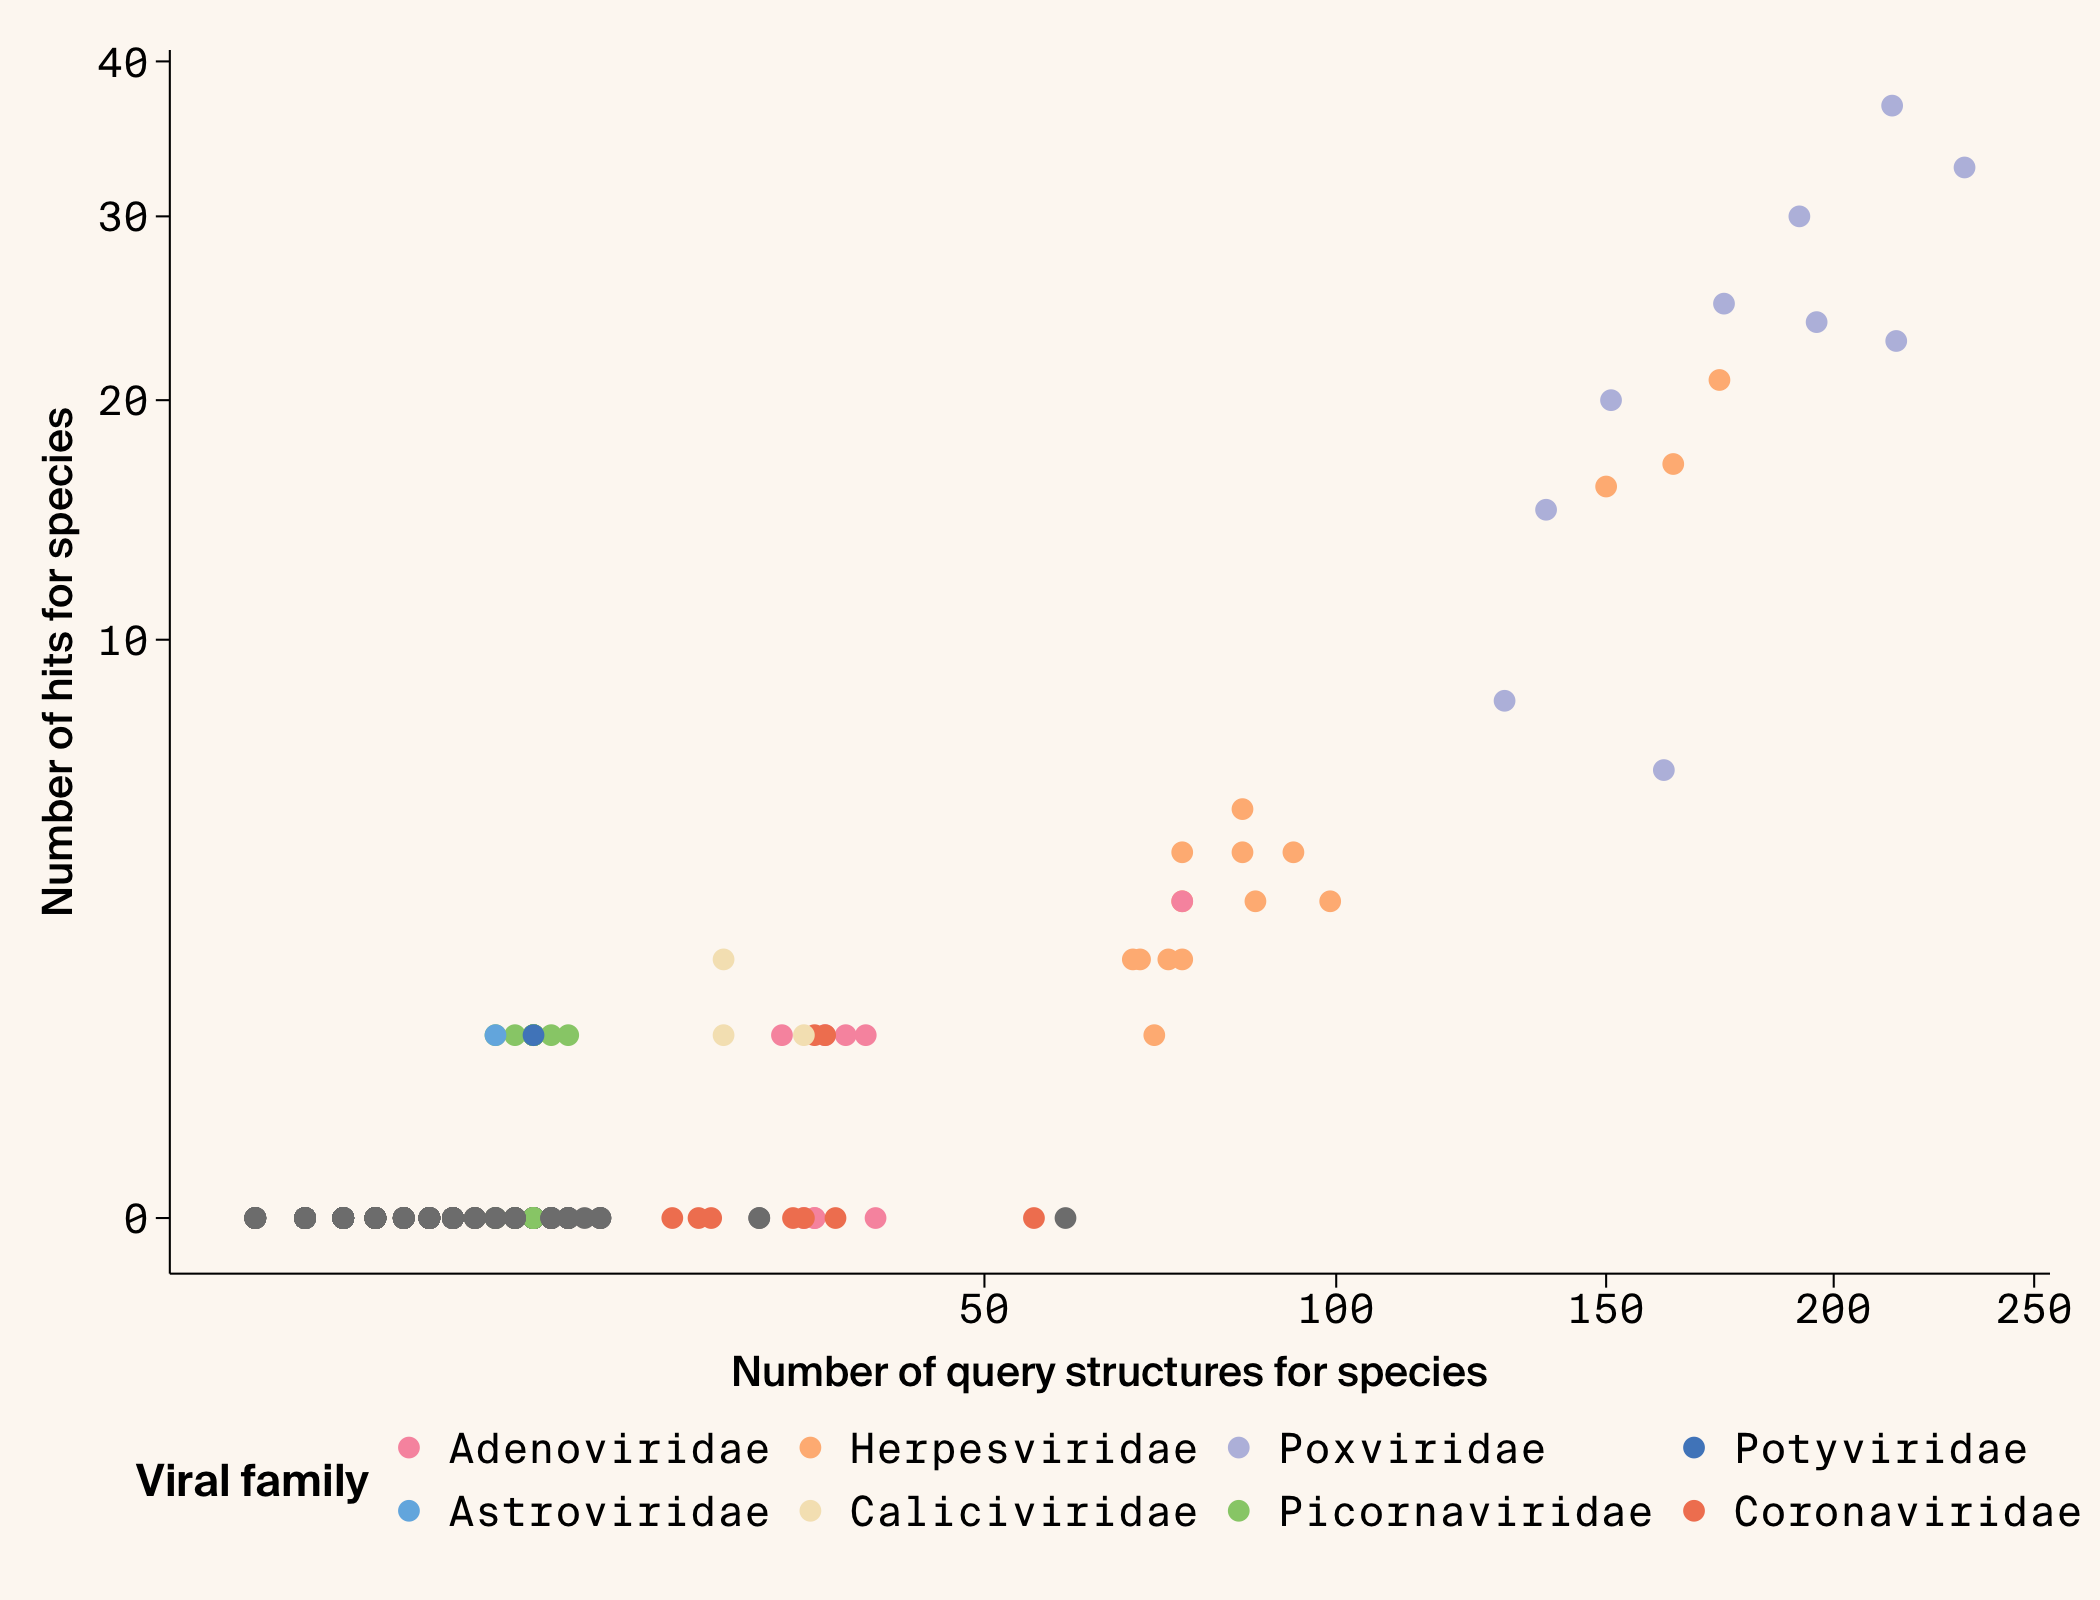

In [157]:
options(repr.plot.width = 10.5, repr.plot.height = 8, repr.plot.res = 200)

ggplot(filtercriteria1_vs_structures, aes(x = n_query_structures, y = n_hits, color = family)) +
  geom_point(size = 3) +
  theme_arcadia() +
  theme(legend.position = "bottom") +
  labs(x = "Number of query structures for species", y="Number of hits for species", color = "Viral family") +
  scale_x_sqrt() +
  scale_y_sqrt() +
  scale_color_manual(values = virus_colors,
                     breaks = c("Adenoviridae", "Astroviridae", "Herpesviridae", "Caliciviridae", "Poxviridae",  "Picornaviridae", "Potyviridae", "Coronaviridae"),
                     labels = c("Adenoviridae", "Astroviridae", "Herpesviridae", "Caliciviridae", "Poxviridae",  "Picornaviridae", "Potyviridae", "Coronaviridae")) 